Install Libraries for RAG Implementation


In [1]:
!pip install langchain
!pip install langchain-community
!pip install chromadb
!pip install langchain-groq
!pip install langchain-openai
!pip install --user -U nltk
!pip install openai
!pip install chromadb tiktoken
!pip install gradio
!pip install tiktoken
!pip install datasets
!pip install langchain lxml
!pip install openai==1.55.3 httpx==0.27.2 --force-reinstall --quiet
!pip install unstructured unstructured-inference langchain openai chromadb
import nltk
#nltk.download('all')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.8 MB/s eta 0:00:00
 

In [ ]:
import os
os.kill(os.getpid(), 9)

Import Libraries

In [1]:

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import DirectoryLoader
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from groq import Groq
from langchain_groq import ChatGroq
import os
#import nest_asyncio  # noqa: E402
#nest_asyncio.apply()
import glob
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import OpenAIEmbeddings
import shutil


Set up OpenAI Environmental Variable

In [2]:

os.environ["OPENAI_API_KEY"] = "sk-proj--"


Perform Exploratory Data Analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = '/content/Dataset-medical.csv'
df = pd.read_csv(file_path)


print("Missing Values:\n", df.isnull().sum())

# Drop rows with missing critical information
df = df.dropna(subset=['question', 'answer'])

# Remove duplicates
df = df.drop_duplicates()


Missing Values:
 question       0
answer         5
source         0
focus_area    14
dtype: int64


In [4]:

# Text cleaning (example for 'answer')
df['answer'] = df['answer'].str.strip()  # Remove extra whitespace
df['answer'] = df['answer'].str.replace(r'\(.*?\)', '', regex=True)  # Remove text in parentheses
df['answer'] = df['answer'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)  # Remove special characters


In [5]:

# 2. Basic Statistics
print("Data Overview:\n", df.info())
print("Summary of Lengths:\n")
df['question_length'] = df['question'].str.len()
df['answer_length'] = df['answer'].str.len()
print(df[['question_length', 'answer_length']].describe())



<class 'pandas.core.frame.DataFrame'>
Index: 16359 entries, 0 to 16411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   question    16359 non-null  object
 1   answer      16359 non-null  object
 2   source      16359 non-null  object
 3   focus_area  16345 non-null  object
dtypes: object(4)
memory usage: 639.0+ KB
Data Overview:
 None
Summary of Lengths:

       question_length  answer_length
count     16359.000000   16359.000000
mean         50.717709    1230.402959
std          16.925605    1567.118055
min          16.000000       4.000000
25%          38.000000     457.500000
50%          48.000000     834.000000
75%          61.000000    1514.000000
max         191.000000   27639.000000


In [6]:
# 3. Distribution of Sources
source_counts = df['source'].value_counts()
print("Source Counts:\n", source_counts)



Source Counts:
 source
GHR                  5430
GARD                 5389
NIDDK                1144
NINDS                1088
MPlusHealthTopics     981
NIHSeniorHealth       769
CancerGov             729
NHLBI                 559
CDC                   270
Name: count, dtype: int64


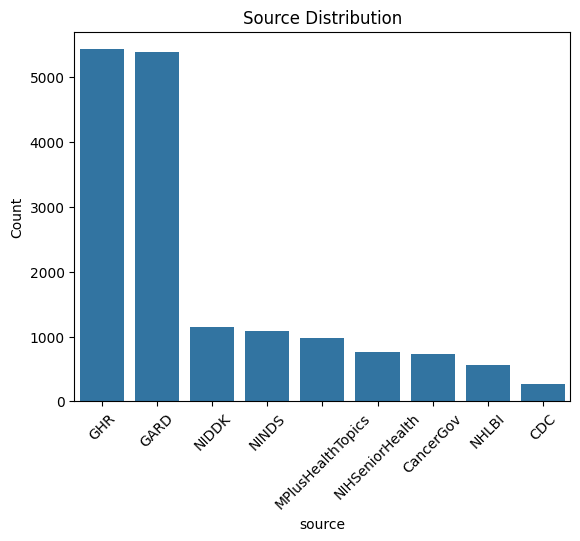

In [7]:

# Plot source distribution
sns.barplot(x=source_counts.index, y=source_counts.values)
plt.title("Source Distribution")
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()


Most Common Question Words:
 first_word
What     11901
How       1962
Is        1446
what       414
Who        322
Do         295
how         16
are          2
Where        1
Name: count, dtype: int64


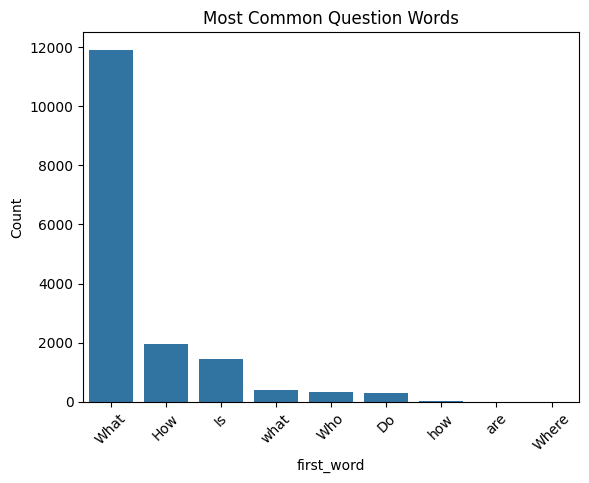

Average Answer Length: 1230.4029586160523


In [8]:


# 4. Question Analysis
# Extract most common question words
df['first_word'] = df['question'].str.split().str[0]
question_word_counts = df['first_word'].value_counts()
print("Most Common Question Words:\n", question_word_counts)

# Plot most common question words
sns.barplot(x=question_word_counts.index, y=question_word_counts.values)
plt.title("Most Common Question Words")
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

# 5. Answer Analysis
# Average answer length
avg_answer_length = df['answer_length'].mean()
print(f"Average Answer Length: {avg_answer_length}")



Record user's voice and save in wav format for further processing

In [10]:
# all imports
from io import BytesIO
from base64 import b64decode
from google.colab import output
from IPython.display import Javascript

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  print("Speak Now...")
  display(Javascript(RECORD))
  sec += 1
  s = output.eval_js('record(%d)' % (sec*1000))
  print("Done Recording !")
  b = b64decode(s.split(',')[1])
  return b #byte stream
# Save the recorded audio to a .wav file
file_name = "/content/output.wav"

# Get the byte stream
audio_data = record(sec=5)

# Save the byte stream to a .wav file
with open(file_name, "wb") as f:
    f.write(audio_data)

print(f"Audio saved as {file_name}")

Speak Now...


<IPython.core.display.Javascript object>

Done Recording !
Audio saved as /content/output.wav


Use whisper for speech to text conversion

In [11]:

from openai import OpenAI
client = OpenAI()

audio_file= open("/content/output.wav", "rb")
transcription = client.audio.transcriptions.create(
model="whisper-1",
file=audio_file
)
print(transcription.text)

There is nothing wrong with this function, but I don't know. I also increased its timer to 5 seconds.


In [12]:
#Set the dataset path
csv_file_paths = ['/content/Dataset-medical.csv']

In [13]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.document_loaders.csv_loader import UnstructuredCSVLoader
import shutil
from langchain_community.document_loaders.csv_loader import CSVLoader

def create_vector_database(file_paths, persist_directory="chroma_db"):

    # Check if the persist directory exists, and clear it if it does
    if os.path.exists(persist_directory):
        shutil.rmtree(persist_directory)  # This clears the previous collection

    all_documents = []  # To store parsed documents
  #Read files
    for file_path in file_paths:
        loader = UnstructuredCSVLoader(file_path)
        documents = loader.load()
        all_documents.extend(documents)
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=5)
    docs = text_splitter.split_documents(all_documents)

    print(f"Length of documents loaded: {len(all_documents)}")
    print(f"Total number of document chunks generated: {len(docs)}")

  #Embedding Model
    embed_model = OpenAIEmbeddings()
    vs = Chroma.from_documents(
        documents=docs,
        embedding=embed_model,
        persist_directory=persist_directory,
        collection_name="rag"
    )

    print('Vector DB created successfully!')
    return vs, embed_model


In [14]:
#Create vector db
vs, embed_model= create_vector_database(csv_file_paths)

Length of documents loaded: 1
Total number of document chunks generated: 11172


<ipython-input-13-5c1c9f773814>:27: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embed_model = OpenAIEmbeddings()


Vector DB created successfully!


In [15]:
#Use LLM Model from Groq
chat_model = ChatGroq(temperature=0,
                      model_name="llama3-70b-8192",
                      api_key="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",)



In [16]:

vectorstore = Chroma(embedding_function=embed_model,
                      persist_directory="chroma_db",
                      collection_name="rag")

retriever=vectorstore.as_retriever(search_kwargs={'k': 5})

<ipython-input-16-0ea28d5f2542>:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(embedding_function=embed_model,


In [17]:
def set_custom_prompt():
    """
    Prompt template for QA retrieval in the healthcare chatbot.
    """
    custom_prompt_template = """
    You are a helpful and knowledgeable AI healthcare assistant specializing in medical conditions.
    Use the provided context to answer the user's question accurately.
    Do not fabricate information. If the answer is not in the context, respond with "I'm sorry, I don't have enough information to answer that."

    Context:
    {context}

    Question:
    {question}

    Ensure your response is clear, concise, and helpful.
    Answer:
    """
    prompt = PromptTemplate(template=custom_prompt_template, input_variables=['context', 'question'])
    return prompt

# Usage
prompt = set_custom_prompt()
prompt


PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='\n    You are a helpful and knowledgeable AI healthcare assistant specializing in medical conditions.\n    Use the provided context to answer the user\'s question accurately.\n    Do not fabricate information. If the answer is not in the context, respond with "I\'m sorry, I don\'t have enough information to answer that."\n\n    Context:\n    {context}\n\n    Question:\n    {question}\n\n    Ensure your response is clear, concise, and helpful.\n    Answer:\n    ')

In [18]:
#Create a chain
qa = RetrievalQA.from_chain_type(llm=chat_model,
                                 chain_type="stuff",
                                 retriever=retriever,
                                 return_source_documents=True,
                                 chain_type_kwargs={"prompt": prompt})


In [19]:

def query_vector_database(query):
    response = qa.invoke(query)
    answer = response['result']
    print(f"Query: {query}")
    print("Answer:")
    print(answer)
    print("\nRetrieved Chunks:")
    for idx, doc in enumerate(response['source_documents']):
        print(f"Chunk {idx + 1}:\n{doc.page_content}\n")

    return response

In [20]:
query_vector_database("What are diabetic kidney disease?")

Query: What are diabetic kidney disease?
Answer:
Diabetic kidney disease, also known as diabetic nephropathy, is a type of kidney disease that occurs in people with diabetes. It happens when high blood glucose levels over time damage the kidneys, causing them to lose their ability to filter waste and excess fluids from the blood. As a result, the body retains more water and salt than it should, leading to swelling (edema) in the legs, feet, ankles, and less often in the hands or face. If left untreated, diabetic kidney disease can progress to kidney failure, requiring dialysis or a kidney transplant.

Retrieved Chunks:
Chunk 1:
in the body. The bodys cells are then starved of energy despite high blood glucose levels. NIDDK Diabetic Kidney Disease What are the symptoms of Diabetic Kidney Disease ? People with diabetic kidney disease do not have symptoms in the early stages. As kidney disease progresses, a person can develop edema, or swelling. Edema happens when the kidneys cannot get r

{'query': 'What are diabetic kidney disease?',
 'result': 'Diabetic kidney disease, also known as diabetic nephropathy, is a type of kidney disease that occurs in people with diabetes. It happens when high blood glucose levels over time damage the kidneys, causing them to lose their ability to filter waste and excess fluids from the blood. As a result, the body retains more water and salt than it should, leading to swelling (edema) in the legs, feet, ankles, and less often in the hands or face. If left untreated, diabetic kidney disease can progress to kidney failure, requiring dialysis or a kidney transplant.',
 'source_documents': [Document(metadata={'source': '/content/Dataset-medical.csv'}, page_content='in the body. The bodys cells are then starved of energy despite high blood glucose levels. NIDDK Diabetic Kidney Disease What are the symptoms of Diabetic Kidney Disease ? People with diabetic kidney disease do not have symptoms in the early stages. As kidney disease progresses, a 

In [22]:
import gradio as gr
import os
from openai import OpenAI

# OpenAI client initialization
client = OpenAI()

# RAG pipeline invocation function
def get_answer(query):
    response = qa.invoke(query)  # Replace with your actual RAG pipeline logic
    answer = response['result']
    return answer

# Function to transcribe recorded audio to text
def speech_to_text(audio_file):
    if audio_file is None:
        return "No audio recorded. Please try again."
    try:
        with open(audio_file, "rb") as file:
            transcription = client.audio.transcriptions.create(
                model="whisper-1",
                file=file
            )
        return transcription.text
    except Exception as e:
        return f"Error transcribing audio: {str(e)}"

# Combined function to handle speech input and query RAG
def transcribe_and_query(audio_file):
    text = speech_to_text(audio_file)
    if "Error" in text:
        return text, "Failed to get an answer."
    answer = get_answer(text)
    return text, answer

# Gradio Interface
interface = gr.Interface(
    fn=get_answer,  # Function to process text input
    inputs=[
        gr.Textbox(label="Ask a Question"),  # User input text
    ],
    outputs=gr.Textbox(label="Answer"),  # Output for the response
    title="RAG-Powered Chat Interface",
    description="Ask a question via text or record your voice to get an answer.",
)

# Additional interface for audio recording and transcription
audio_interface = gr.Interface(
    fn=transcribe_and_query,  # Function to handle audio file input
    inputs=[
        gr.Audio(type="filepath", label="Record or Upload Audio"),  # Audio input
    ],
    outputs=[
        gr.Textbox(label="Transcribed Text"),  # Transcribed text
        gr.Textbox(label="Answer"),  # RAG pipeline answer
    ],
    title="Speech-to-Text Powered Chat Interface",
    description="Record your voice or upload an audio file, and I'll transcribe and answer your question.",
)

# Combine both interfaces in a tabbed layout
combined_interface = gr.TabbedInterface(
    [interface, audio_interface],
    ["Text Input", "Speech Input"]
)

# Launch the interface
if __name__ == "__main__":
    combined_interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9bd34ac870aa09b257.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
